In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import csv
import string
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.applications import resnet, ResNet50,VGG16,ResNet101, VGG19
import cv2
import random
import shutil
import imutils
from PIL import Image

In [2]:
src_dir = './dataset/'

In [3]:
# Set variable for sub-directories
normal_dir = os.path.join(src_dir, 'normal')
cataract_dir = os.path.join(src_dir, 'cataract')
glaucoma_dir = os.path.join(src_dir, 'glaucoma')
diabetic_retinopathy_dir = os.path.join(src_dir, 'diabetic_retinopathy')

# Get the list of all the images
normal_dir_content = os.listdir(normal_dir)
cataract_dir_content = os.listdir(cataract_dir)
glaucoma_dir_content = os.listdir(glaucoma_dir)
diabetic_retinopathy_dir_content = os.listdir(diabetic_retinopathy_dir)

# shuffle the data
random.shuffle(normal_dir_content)
random.shuffle(cataract_dir_content)
random.shuffle(glaucoma_dir_content)
random.shuffle(diabetic_retinopathy_dir_content)

In [4]:
# split the data into training, validation, and testing sets using a 80-10-10 split
def split_data(data):
    training_idx = int(len(data) * 0.8)
    validation_idx = int(len(data) * 0.9)
    
    train_split = data[:training_idx]
    val_idx = data[training_idx:validation_idx]
    test_split = data[validation_idx:]
    
    return train_split, val_idx, test_split

normal_train, normal_val, normal_test = split_data(normal_dir_content)
cataract_train, cataract_val, cataract_test = split_data(cataract_dir_content)
glaucoma_train, glaucoma_val, glaucoma_test = split_data(glaucoma_dir_content)
diabetic_retinopathy_train, diabetic_retinopathy_val, diabetic_retinopathy_test = split_data(diabetic_retinopathy_dir_content)

In [5]:
data_split_dir = os.path.join(src_dir, '_dataset_split')
if not os.path.exists(data_split_dir):
    os.mkdir(data_split_dir)
    print(f'Created directory: {data_split_dir}')

# List of subdirectories
subdirs = ['training', 'validation', 'test']

# Loop over each subdirectory
for subdir in subdirs:
    # Full path to the subdirectory
    dir_path = os.path.join(src_dir, '_dataset_split', subdir)
    
    # Check if the subdirectory exists
    if os.path.exists(dir_path):
        # If it does, remove it (and all its contents)
        print(f'Removing existing directory: {dir_path}')
        shutil.rmtree(dir_path)
    
    # Create the subdirectory
    os.mkdir(dir_path)

Removing existing directory: ./dataset/_dataset_split/training
Removing existing directory: ./dataset/_dataset_split/validation
Removing existing directory: ./dataset/_dataset_split/test


In [6]:
# Now let's copy the images into the directories
for subdir, data in zip(subdirs, [(normal_train, cataract_train, glaucoma_train, diabetic_retinopathy_train),
                                  (normal_val, cataract_val, glaucoma_val, diabetic_retinopathy_val),
                                  (normal_test, cataract_test, glaucoma_test, diabetic_retinopathy_test)]):
    for label, label_data in zip(['normal', 'cataract', 'glaucoma', 'diabetic_retinopathy'], data):
        # Create label specific subdirectory path
        label_dir = os.path.join(data_split_dir, subdir, label)

        # Create the label specific subdirectory
        os.mkdir(label_dir)

        # Copy each file to the right directory
        for filename in label_data:
            # The source file
            src_file = os.path.join(src_dir, label, filename)

            # The destination file
            dst_file = os.path.join(label_dir, filename)

            # Copy the file
            shutil.copy2(src_file, dst_file)

In [7]:
def get_image_size_range(dataset_path):
    widths = []
    heights = []
    for root, _, files in os.walk(dataset_path):
        for f in files:
            if f.endswith('.jpg') or f.endswith('.png'):
                img_path = os.path.join(root, f)
                img = Image.open(img_path)
                widths.append(img.width)
                heights.append(img.height)
    
    min_width = min(widths)
    max_width = max(widths)
    min_height = min(heights)
    max_height = max(heights)
    
    print(f'Min width: {min_width}')
    print(f'Max width: {max_width}')
    print(f'Min height: {min_height}')
    print(f'Max height: {max_height}')
    
get_image_size_range(os.path.join(data_split_dir, 'training'))

Min width: 256
Max width: 2592
Min height: 256
Max height: 1728


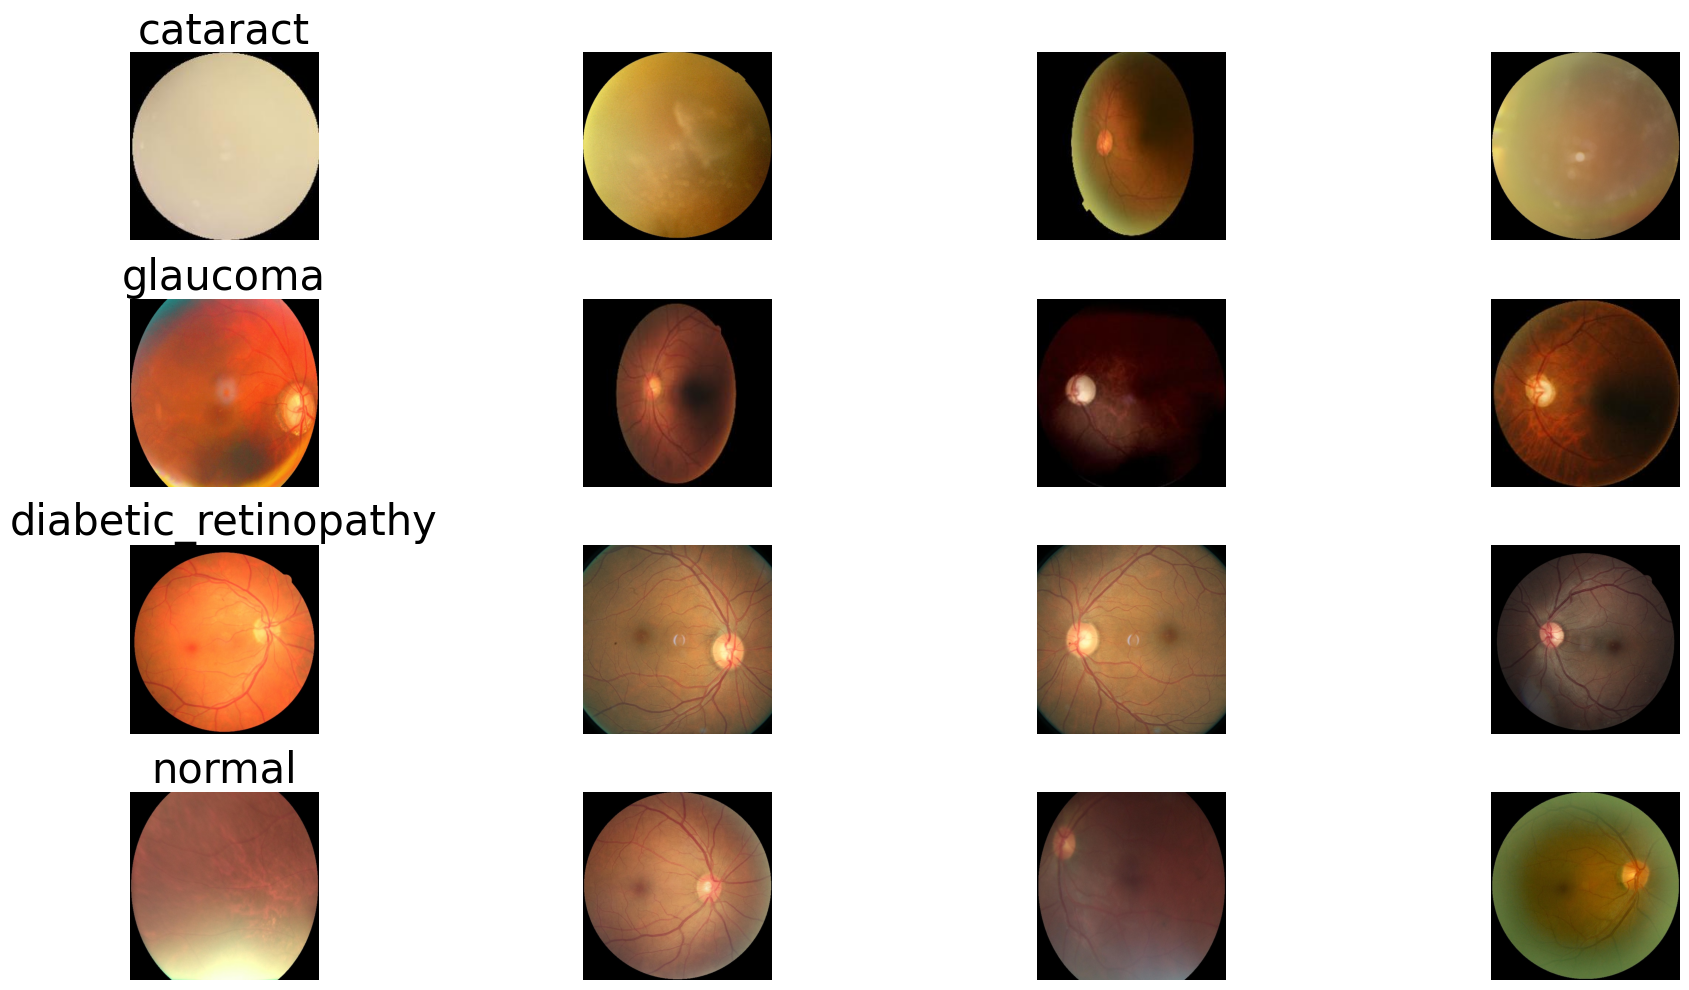

In [8]:
# Get a list of all subdirectories paths (each one is a class label)
training_split_dir = os.path.join(data_split_dir, 'training')
subdirs = [os.path.join(training_split_dir, subdir) for subdir in os.listdir(training_split_dir)]

# Specify the number of columns for your plot
ncols = 4

# Set up matplotlib fig
fig, ax = plt.subplots(len(subdirs), ncols, figsize=(20, 10))

# For each subdirectory, select random images
for i, subdir in enumerate(subdirs):
    subdir_images = os.listdir(subdir) # Get list of dir contents
    random_image_names = random.sample(subdir_images, ncols) # Get a sample of dir content
    images = [os.path.join(subdir, img_name) for img_name in random_image_names] # Append path to each sample image
    
    for j, img_path in enumerate(images):
        # Set up subplot; subplot indices start at 1
        sp = ax[i, j]
        if j == 0:
            sp.set_title(os.path.basename(subdir), fontsize=30)  # set title to the first image of each row
        sp.axis('Off') # Don't show axes (or gridlines)

        img = mpimg.imread(img_path)
        sp.imshow(img) # Show random image

plt.tight_layout()
plt.show()

# Model Development

In [9]:
# from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input


pre_trained_model = EfficientNetB0(input_shape = (256, 256, 3), 
                          include_top = False, 
                          classifier_activation='softmax',
                          classes=1)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
    layer.trainable = False


In [10]:
TRAIN_DIR = os.path.join(data_split_dir, 'training')
VAL_DIR = os.path.join(data_split_dir, 'validation')
TEST_DIR = os.path.join(data_split_dir, 'test')

IMG_SIZE = (256, 256)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    preprocessing_function=preprocess_input)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True)

validation_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False)

Found 3372 images belonging to 4 classes.
Found 422 images belonging to 4 classes.
Found 423 images belonging to 4 classes.


In [11]:
EPOCHS = 30
myCallback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    mode='min',
    patience=3,
    restore_best_weights=True
)

In [19]:
from tensorflow.keras.optimizers.legacy import Adam, Adamax

model = tf.keras.Sequential([
    pre_trained_model,  # Pretrained base
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    tf.keras.layers.Dense(256, kernel_regularizer= tf.keras.regularizers.l2(l= 0.016), activity_regularizer= tf.keras.regularizers.l1(0.006),
                bias_regularizer= tf.keras.regularizers.l1(0.006), activation= 'relu'),
    tf.keras.layers.Dropout(rate= 0.45, seed= 123),
    tf.keras.layers.Dense(4, activation="softmax")
])

model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['acc'])

In [20]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 8, 8, 1280)        4049571   
 )                                                               
                                                                 
 flatten_2 (Flatten)         (None, 81920)             0         
                                                                 
 batch_normalization_1 (Bat  (None, 81920)             327680    
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 256)               20971776  
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                

In [21]:
history = model.fit(train_generator, epochs=EPOCHS, validation_data=validation_generator, verbose=1, callbacks=[myCallback])

Epoch 1/30
106/106 [==============================] - 46s 408ms/step - loss: 18.9193 - acc: 0.8022 - val_loss: 11.9700 - val_acc: 0.8175
Epoch 2/30
106/106 [==============================] - 42s 394ms/step - loss: 12.6380 - acc: 0.8556 - val_loss: 8.6853 - val_acc: 0.8886
Epoch 3/30
106/106 [==============================] - 41s 387ms/step - loss: 8.6747 - acc: 0.8983 - val_loss: 6.6295 - val_acc: 0.8815
Epoch 4/30
106/106 [==============================] - 41s 387ms/step - loss: 6.2562 - acc: 0.9009 - val_loss: 5.2854 - val_acc: 0.8673
Epoch 5/30
106/106 [==============================] - 42s 391ms/step - loss: 4.7892 - acc: 0.9208 - val_loss: 4.1956 - val_acc: 0.8768
Epoch 6/30
106/106 [==============================] - 42s 393ms/step - loss: 3.8289 - acc: 0.9205 - val_loss: 3.3814 - val_acc: 0.8863
Epoch 7/30
106/106 [==============================] - 41s 389ms/step - loss: 3.0809 - acc: 0.9247 - val_loss: 2.7666 - val_acc: 0.9028
Epoch 8/30
106/106 [==============================] 

# Eval

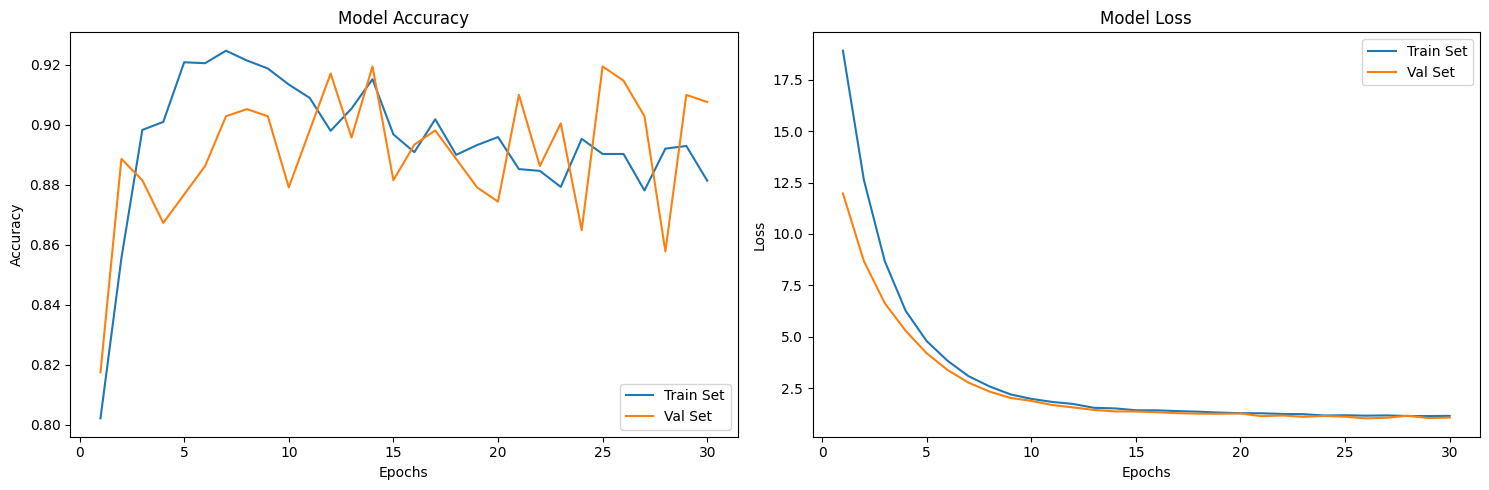

In [22]:
# plot model performance
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [23]:
def metrics2dt(acc, rc, pr, f1):
    return pd.DataFrame(data={"Accuracy":acc, "Recall":rc, "Precision":pr, "F1-Score":f1}, index=[0])

def show_metrics(y_true, y_pred):
    recall = tf.keras.metrics.Recall()
    precision = tf.keras.metrics.Precision()
    accuracy = tf.keras.metrics.Accuracy()

    recall.update_state(y_true, y_pred)
    recall = recall.result().numpy()
    
    precision.update_state(y_true, y_pred)
    precision = precision.result().numpy()
    
    accuracy.update_state(y_true, y_pred)
    accuracy = accuracy.result().numpy()
    
    f1_score = 0
    if recall+precision != 0:
        f1_score = 2 * ((recall*precision)/(recall+precision))
    
    return metrics2dt(accuracy, recall, precision, f1_score)

14/14 [==============================] - 6s 351ms/step


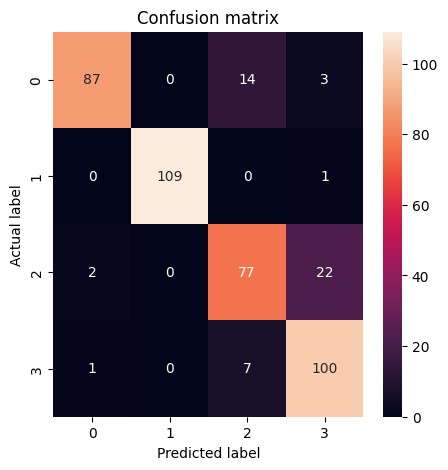

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Assuming that you have the true labels
true_labels = test_generator.classes

# Get the predicted probabilities from the model
predicted_probs = history.model.predict(test_generator, steps=len(test_generator))

# Convert probabilities to class labels: if you're working on a binary classification problem
# predicted_labels = [1 if prob > 0.5 else 0 for prob in predicted_probs]

# If you're working on a multi-class classification problem, use argmax
predicted_labels = np.argmax(predicted_probs, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot it using seaborn
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


In [25]:
show_metrics(true_labels, predicted_labels)

,Accuracy,Recall,Precision,F1-Score
0,0.881797,0.990596,0.948949,0.969325


In [26]:
loss, accuracy = model.evaluate(test_generator, steps=len(test_generator))

14/14 [==============================] - 5s 368ms/step - loss: 1.1085 - acc: 0.8818


In [33]:
from keras.preprocessing import image

# Load the image and preprocess it
img = image.load_img('R.jpeg', target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) 
img_array = preprocess_input(img_array) 

# Make prediction
prediction = model.predict(img_array)
print(prediction)

# Decode the result into class name
g_dict = test_generator.class_indices
classes = list(g_dict.keys())
print(classes[np.argmax(prediction)])

1/1 [==============================] - 0s 82ms/step
[[0.03107783 0.26911625 0.11689103 0.5829149 ]]
normal


In [28]:
import itertools

def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	'''
	This function plot confusion matrix method from sklearn package.
	'''

	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)

	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

/var/folders/x6/mx2zsdgx0v3bp894xsfqfgp00000gn/T/ipykernel_10558/223118530.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_generator)


Confusion Matrix, Without Normalization
[[ 87   0  14   3]
 [  0 109   0   1]
 [  2   0  77  22]
 [  1   0   7 100]]


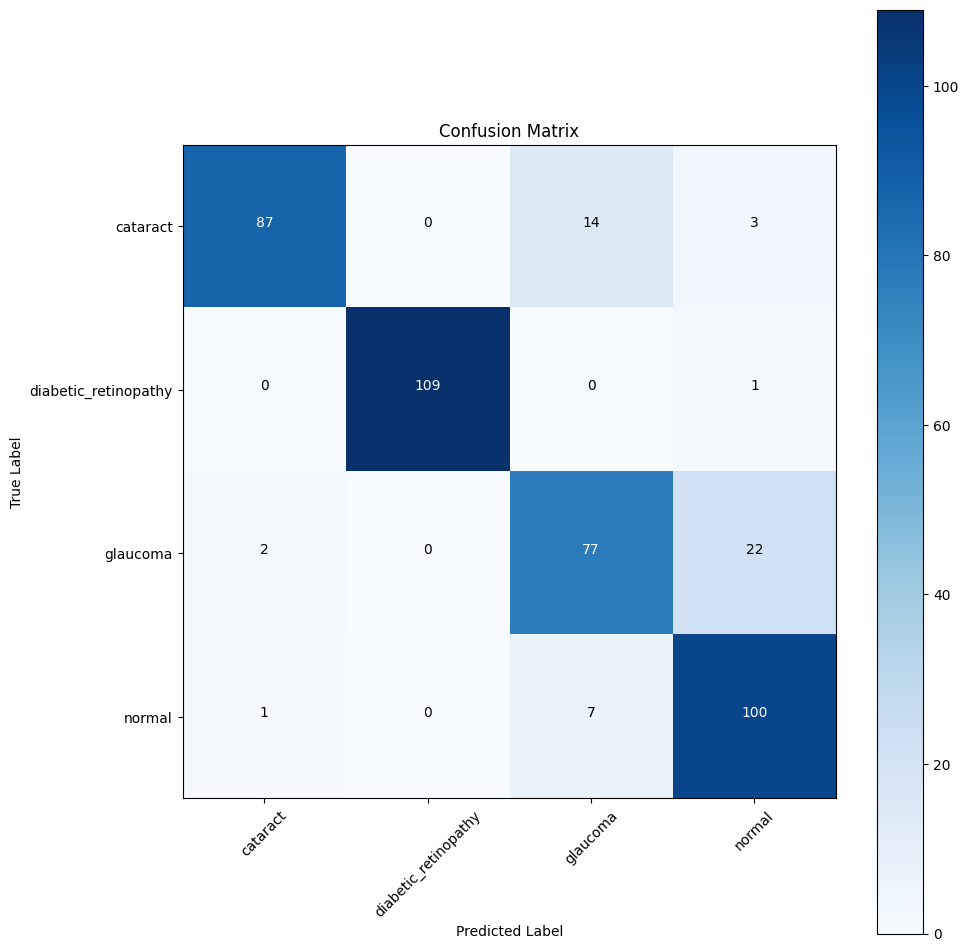

In [29]:
preds = model.predict_generator(test_generator)
y_pred = np.argmax(preds, axis=1)

# Confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')